### Libraries

In [31]:
%matplotlib inline
import numpy as np
import os
from glob import glob
# import cv2
import skimage.io as skio
import matplotlib.pyplot as plt
import torch
from sklearn.feature_extraction import image

### Load data

In [40]:
refDir = r'/media/banikr2/DATA/Diesel_block/4_refocus'
segDir = r'/media/banikr2/DATA/Diesel_block/5_segmented'
mskDir = r'/media/banikr2/DATA/Diesel_block/6_binarymask'
refFiles = sorted(glob(os.path.join(refDir, '*.tif')))#.sort()
segFiles = sorted(glob(os.path.join(segDir, '*.tif')))#.sort()
mskFiles = sorted(glob(os.path.join(mskDir, '*.png')))

Same number of image slices:

In [42]:
len(refFiles), len(segFiles), len(mskFiles)

(294, 294, 294)

In [43]:
# im = cv2.imread(refFiles[0], -1)
im = skio.imread(refFiles[20], plugin="tifffile")
sg = skio.imread(segFiles[20], plugin="tifffile")
mk = skio.imread(mskFiles[20])

In [11]:
im.dtype, im.shape, sg.dtype, sg.shape

(dtype('uint8'), (900, 900, 3), dtype('uint8'), (900, 900, 3))

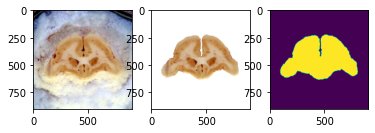

In [47]:
plt.subplot(131)
plt.imshow(im)
# plt.axis("off")
plt.subplot(132)
plt.imshow(sg)
# plt.axis("off")
plt.subplot(133)
plt.imshow(mk)
plt.show()

``` matlab
>> whos img21
  Name         Size                 Bytes  Class    Attributes

  img21      900x900x3            2430000  uint8  

>> whos seg21
  Name        Size                 Bytes  Class    Attributes
  seg21      900x900x3            2430000  uint8              
```

ground truth should be converted to a binary mask?<br> $0$ --> non-brain part of the slice <br> $1$ --> brain part of the slice

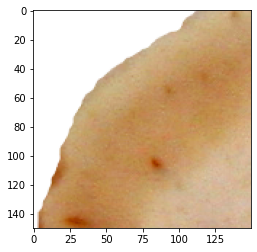

In [12]:
sg_chunk = sg[250:400,200:350,:]
plt.imshow(sg_chunk)

Convert to grayscale `rgb2gray` in *Matlab*

|<p>|<p>|<p>|<p>|
|:-:|:-:|:-:|:-:|
| <img src="../Images/rgb_21.jpg" style="width: 200px;"/> _slice #020_ |<img src="../Images/seg_21.jpg" style="width: 200px;"/> |<img src="../Images/grayscale_21.jpg" style="width: 200px;"/> |<img src="../Images/binarymask_21.jpg" style="width: 200px;"/>  |
| <img src="../Images/rgb_201.jpg" style="width: 200px;"/> _slice #200_|<img src="../Images/seg_201.jpg" style="width: 200px;"/>|<img src="../Images/grayscale_201.jpg" style="width: 200px;"/> |<img src="../Images/binarymask_201.jpg" style="width: 200px;"/>  |
|_refocused image(RGB)_|_segmented image(RGB)_|_grayscaled_|_binary mask_|

non-brain pixels were removed by `regionprops` Matlab

|<p>|<p>|
|:-:|:-:|
| <img src="../Images/binarymask_190.png" style="width: 200px;"/> |<img src="../Images/binarybrainmask_190.png" style="width: 200px;"/> |

patch size : `128,128,3` or `224,224,3` <br>
The following code should cover the whole image/mask given patchsize and stepsize

1 0 0
2 0 100
3 0 200
4 0 300
5 0 400
6 0 500
7 0 600
8 0 676
9 100 0
10 100 100
11 100 200
12 100 300
13 100 400
14 100 500
15 100 600
16 100 676
17 200 0
18 200 100
19 200 200
20 200 300
21 200 400
22 200 500
23 200 600
24 200 676
25 300 0
26 300 100
27 300 200
28 300 300
29 300 400
30 300 500
31 300 600
32 300 676
33 400 0
34 400 100
35 400 200
36 400 300
37 400 400
38 400 500
39 400 600
40 400 676
41 500 0
42 500 100
43 500 200
44 500 300
45 500 400
46 500 500
47 500 600
48 500 676
49 600 0
50 676 0
51 600 100
52 676 100
53 600 200
54 676 200
55 600 300
56 676 300
57 600 400
58 676 400
59 600 500
60 676 500
61 600 600
62 600 676
63 676 600
64 676 676
Happens


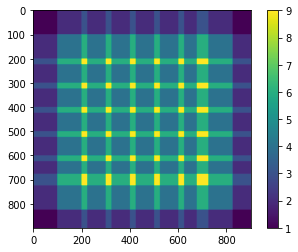

In [131]:
overlapMat = np.zeros_like(im[...,0])
patchsize = [224, 224]
stepsize = [100, 100]
count=0
for r in range(0,im.shape[0]-patchsize[0],stepsize[0]):
    for c in range(0,im.shape[1]-patchsize[1], stepsize[1]):
        count+=1
        print(count, r,c) # r= 0, c=700
        overlapMat[r:r+patchsize[0],c:c+patchsize[1]]+=1
    #break
        if c+stepsize[1]+patchsize[1]>im.shape[1]:
            count+=1
            print(count, r,im.shape[1]-patchsize[1])
            overlapMat[r:r+patchsize[0],im.shape[1]-patchsize[1]:im.shape[1]]+=1
        if r+stepsize[0]+patchsize[0]>im.shape[0]:
            count+=1
            print(count, im.shape[0]-patchsize[0],c)
            overlapMat[im.shape[0]-patchsize[0]:im.shape[0],c:c+patchsize[1]]+=1
        if r+stepsize[0]+patchsize[0]>im.shape[0] and c+stepsize[1]+patchsize[1]>im.shape[1]:
            count+=1
            print(count, im.shape[0]-patchsize[0], im.shape[1]-patchsize[1])
            overlapMat[im.shape[0]-patchsize[0]:im.shape[0],im.shape[1]-patchsize[1]:im.shape[1]]+=1
            print("Happens")

c = plt.imshow(overlapMat)
plt.colorbar(c)
plt.show()

In [26]:
patches = torch.tensor(sg).unfold(0, 128, 10).unfold(1, 128, 10).unfold(2, 3, 3)
print(patches.shape)

torch.Size([78, 78, 1, 128, 128, 3])


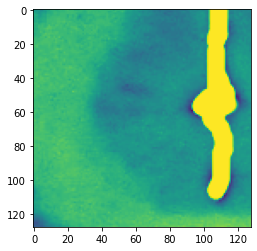

In [30]:
plt.imshow(patches[31,35,0,:,:,1])

In [37]:
patches_ = image.extract_patches_2d(im, (128,128),max_patches=20, random_state=0)

In [48]:
mskpatches = image.extract_patches_2d(mk, (128,128), max_patches=20, random_state=0)

In [49]:
mskpatches.shape

(20, 128, 128)

In [38]:
patches_.shape

(20, 128, 128, 3)

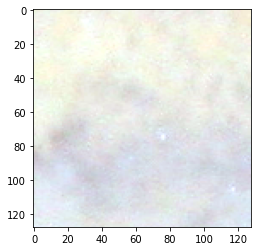

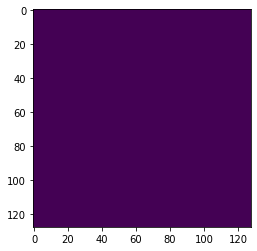

In [51]:
plt.imshow(patches_[17,...])
plt.show()
plt.imshow(mskpatches[17,...])

### ToDo:
1. ~~Remove isolated pixels outside brain.~~
2. ~~Create binary/target masks for all the slices and datastructure...~~
3. Tiling for image and masks.
4. Dataset/DataLoader in pytorch.
5. Network architecture.
6. Loss function(binary cross entropy or ?)

### Questions/doubt:
1. How to validate the created binary masks? 
2. ~~There are small pixels scattered outside brain regions, do we need to remove those by erosion or other morphological operations?~~
 - ~~**caveats:** some slices have unit brain, some have two or three parts, _largest connected component_ may not work.~~